In [1]:
import requests
import zipfile
import os

TEXT8_URL = "https://mattmahoney.net/dc/text8.zip"

def download_text8(out_path: str) -> None:
    """
    Downloads the text8 dataset and saves it to the specified path.
    """
    print(f"Downloading text8 dataset to {out_path}")
    r = requests.get(TEXT8_URL)
    with open(out_path, "wb") as f:
        f.write(r.content)
    print("Done!")

def extract_text8(zip_path: str, out_path: str) -> None:
    """
    Extracts the text8 dataset from the specified zip file to the specified path.
    """
    print(f"Extracting text8 dataset from {zip_path} to {out_path}")
    with zipfile.ZipFile(zip_path, "r") as f:
        f.extractall(out_path)
    print("Done!")

def get_text8(out_path: str) -> str:
    """
    Downloads and extracts the text8 dataset to the specified path.
    The returned path is the path to the extracted text8 file.
    """
    zip_path = out_path + ".zip"
    if not os.path.exists(zip_path):
        download_text8(zip_path)
    if not os.path.exists(out_path):
        extract_text8(zip_path, out_path)
    return os.path.join(out_path, "text8")

os.makedirs("data", exist_ok=True)
path = get_text8("data/text8")
print(path)
with open(path, "r") as f:
    text = f.read()
text[:100]

data/text8/text8


' anarchism originated as a term of abuse first used against early working class radicals including t'

In [2]:
import string
from tok import CharacterTokenizer

vocab = string.ascii_lowercase + " "
tok = CharacterTokenizer(vocab, model_max_length=256)
# check that encoding then decoding is the identity function
a = tok.decode(tok.encode(text[:100]))
b = text[:100]
assert a == b, f"Encoding then decoding is not the identity function! {a} != {b}"


In [3]:
# tokenize the entire text
tokens = tok.encode(text, return_tensors="pt")
tokens.shape

Token indices sequence length is longer than the specified maximum sequence length for this model (100000000 > 256). Running this sequence through the model will result in indexing errors


torch.Size([1, 100000000])

In [4]:
import torch
from torch import Tensor
import random
from jaxtyping import Int
from typing import Generator
from torch.utils.data import Dataset, DataLoader

def chunk_dataset(tokens: Int[Tensor, "1 D"], chunk_size: int, rng: random.Random) -> Int[Tensor, "n_chunks D"]:
    """
    Chunks the dataset into sequences of length chunk_size, randomly shuffled.
    """
    chunked = list(tokens.chunk(tokens.shape[-1] // chunk_size, dim=-1))
    rng.shuffle(chunked)
    return torch.cat(chunked, dim=0)

class Text8Dataset(Dataset):

    def __init__(self, tokens: Int[Tensor, "1 D"], chunk_size: int, rng: random.Random):
        super().__init__()
        self.tokens = tokens
        self.chunk_size = chunk_size
        self.rng = rng
        self.tokens_chunked = chunk_dataset(self.tokens, chunk_size, rng)

    def __len__(self) -> int:
        return self.tokens.shape[-1] // self.chunk_size

    def __getitem__(self, index: int) -> Int[Tensor, "1 D"]:
        return self.tokens_chunked[index]

def get_optim_groups(model: torch.nn.Module, weight_decay: float):
    # separate out all parameters to those that will and won't experience regularizing weight decay
    decay = set()
    no_decay = set()
    whitelist_weight_modules = (torch.nn.Linear, )
    blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
    for mn, m in model.named_modules():
        for pn, p in m.named_parameters():
            fpn = '%s.%s' % (mn, pn) if mn else pn # full param name
            # random note: because named_modules and named_parameters are recursive
            # we will see the same tensors p many many times. but doing it this way
            # allows us to know which parent module any tensor p belongs to...
            if pn.endswith('bias'):
                # all biases will not be decayed
                no_decay.add(fpn)
            elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                # weights of whitelist modules will be weight decayed
                decay.add(fpn)
            elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                # weights of blacklist modules will NOT be weight decayed
                no_decay.add(fpn)

    # validate that we considered every parameter
    param_dict = {pn: p for pn, p in model.named_parameters()}
    inter_params = decay & no_decay
    union_params = decay | no_decay
    assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
    assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                % (str(param_dict.keys() - union_params), )

    # create the pytorch optimizer object
    optim_groups = [
        {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": weight_decay},
        {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
    ]
    return optim_groups

In [5]:
# !wandb login <KEY>

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sidsidsid (conjecture_engineering). Use `wandb login --relogin` to force relogin


Dataset has 390625 chunks of size 256.
loading model...
model_type: None
n_layer: 24
n_head: 12
n_embd: 768
vocab_size: 30
block_size: 257
embd_pdrop: 0.0
resid_pdrop: 0.0
attn_pdrop: 0.0

number of parameters: 170.33M
gpt loaded
bfn loaded
training...


  0%|          | 0/10000 [00:00<?, ?it/s]

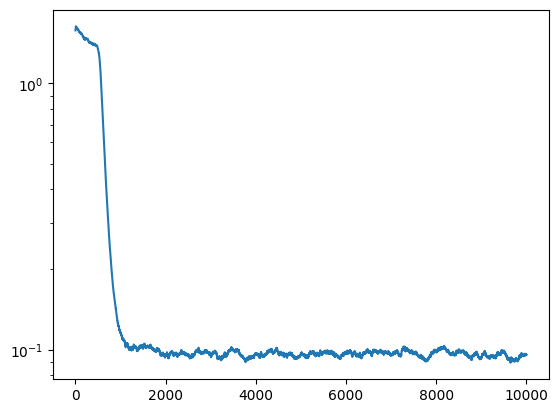

In [6]:
from torch.optim import AdamW
from tqdm.auto import tqdm
from bfn import get_gpt_net, BayesianFlowNetwork
import matplotlib.pyplot as plt
import wandb
from dataclasses import dataclass

@dataclass
class Config:
    LR = 1e-4
    WEIGHT_DECAY = 1e-1
    BATCH_SIZE = 16
    SEQ_LEN = D = 256
    HIDDEN_DIM = 768
    NUM_LAYERS = 24
    NUM_HEADS = 12
    DROPOUT = 0.0
    SEED = 0
    ADAM_BETAS = (0.9, 0.98)
    N_BATCHES = 10000
    VOCAB_SIZE = tok.vocab_size
    LOSS_EMA = 0.99

CONFIG = Config()

wandb.init(project="bfn", entity="conjecture_engineering", config=CONFIG.__dict__)

rng = random.Random(CONFIG.SEED)
torch_rng = torch.Generator()
torch_rng.manual_seed(CONFIG.SEED)
dataset = Text8Dataset(tokens, chunk_size=CONFIG.SEQ_LEN, rng=rng)
dataloader = DataLoader(
    dataset=dataset,
    batch_size=CONFIG.BATCH_SIZE,
    drop_last=True,
    shuffle=True,
    pin_memory=True,
    generator=torch_rng,
)
dataloader_iter = iter(dataloader)
print(f"Dataset has {len(dataset)} chunks of size {CONFIG.SEQ_LEN}.")
print("loading model...")
gpt = get_gpt_net(D=CONFIG.D + 1, vocab_size=CONFIG.VOCAB_SIZE, hidden_dim=CONFIG.HIDDEN_DIM, num_layers=CONFIG.NUM_LAYERS, num_heads=CONFIG.NUM_HEADS, dropout=CONFIG.DROPOUT) # D+1 because timestep is added to the last position in the sequence
print('gpt loaded')
bfn = BayesianFlowNetwork(gpt, D=CONFIG.D, vocab_size=CONFIG.VOCAB_SIZE, beta=3.0)
print('bfn loaded')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
bfn = bfn.to(device)
param_groups = get_optim_groups(bfn, weight_decay=CONFIG.WEIGHT_DECAY)
optim = AdamW(param_groups, lr=CONFIG.LR, betas=CONFIG.ADAM_BETAS)

losses = []
print("training...")
pbar = tqdm(range(CONFIG.N_BATCHES))
for i in pbar:
    optim.zero_grad()

    X = next(dataloader_iter).to(device)
    loss = bfn.process(X)
    loss.backward()

    optim.step()

    wandb.log({"train/loss": loss.item()})
    losses.append(loss.item())
    if i % 1000 == 0:
        pbar.set_description(f"loss: {loss.item():.4f}")

# smooth losses by exponential moving average
losses_ema = []
ema = losses[0]
for loss in losses:
    ema = CONFIG.LOSS_EMA * ema + (1 - CONFIG.LOSS_EMA) * loss
    losses_ema.append(ema)

plt.plot(losses_ema)
plt.yscale("log")
plt.show()

In [8]:
# save out model
torch.save(bfn.net.state_dict(), "bfn_v1.pt")

AttributeError: 'BayesianFlowNetwork' object has no attribute 'net'

In [12]:
# sample:
bfn = bfn.eval()
tokens = bfn.sample(batch_size=1, nb_steps=100, device=device)
print(tok.decode(tokens[0]))

ata asneaniiqb  isliadmwb t eeispoirtiioeregehnid  beraartv sre i s a hl   iannt yiittlvetebecnbn yiaia ftes kmoarwlv r xal  sdlscl oo inlietanoeeelrttrthuuaua   eno celaisyseleyu g nlsiceaeesbit iany s snh epdtenleucrmolr of  tihldsrcoai iun  nmenerghfp n


In [10]:
# ev

BayesianFlowNetwork(
  (layer): GPT(
    (transformer): ModuleDict(
      (wte): Linear(in_features=31, out_features=768, bias=False)
      (wpe): Embedding(257, 768)
      (drop): Dropout(p=0.0, inplace=False)
      (h): ModuleList(
        (0-23): 24 x Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): CausalSelfAttention(
            (c_attn): Linear(in_features=768, out_features=2304, bias=True)
            (c_proj): Linear(in_features=768, out_features=768, bias=True)
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): ModuleDict(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            (act): NewGELU()
            (dropout): Dropout(p=0.0, inplace=False)
          )
  